<a href="https://colab.research.google.com/github/Emersonmiady/bootcamp-alura-ds/blob/main/modulo_6/machine_learning_modelos_metricas_e_validacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 6

## 01. Workflow de Machine Learning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [ ]:
link = '/content/drive/MyDrive/Alura Bootcamp DS/Módulo 6/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(link)
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
def preenche_tabela(df):
    features_continuas_colunas = df.iloc[:, 13:-2].columns
    features_continuas = df.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = df.iloc[:, :13]
    saida = df.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
    dados_finais.columns = df.columns
    return dados_finais

In [ ]:
def prepare_window(rows):
    if np.any(rows['ICU']):
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW'] == '0-2']

In [ ]:
dados_limpos = preenche_tabela(dados)

In [ ]:
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

In [ ]:
# Removendo os dados em que a "WINDOW" é igual a "0-2" e o "ICU" igual a 1 (direto pra UTI)
a_remover = dados_limpos.query('WINDOW == "0-2" and ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_limpos = dados_limpos.dropna()
display(dados_limpos.describe())

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
dados_limpos = dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

In [ ]:
dados_limpos['AGE_PERCENTIL'] = dados_limpos['AGE_PERCENTIL'].astype('category').cat.codes

In [ ]:
np.random.seed(73246)

x_columns = dados.columns
y = dados_limpos['ICU']
X = dados_limpos[x_columns].drop(['ICU', 'WINDOW'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
modelo = DummyClassifier()
modelo.fit(X_train, y_train)

y_prediction = modelo.predict(X_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [ ]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(X_train, y_train)

y_prediction = modelo.predict(X_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

### Desafio 01: Transformar a coluna AGE_PERCENTIL em dados categóricos, mas utilizando outro método.

### Desafio 02: Verificar o impacto da mudança nos resultados.

In [ ]:
dados_limpos_dummies = preenche_tabela(dados)

In [ ]:
a_remover = dados_limpos_dummies.query('WINDOW == "0-2" and ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos_dummies = dados_limpos_dummies.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_limpos_dummies = dados_limpos_dummies.dropna()

In [ ]:
dados_limpos_dummies = dados_limpos_dummies.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)
dados_limpos_dummies = pd.get_dummies(dados_limpos, columns=['AGE_PERCENTIL'], 
                                      drop_first=True)

In [ ]:
dados_limpos_dummies.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,AGE_PERCENTIL_1,AGE_PERCENTIL_2,AGE_PERCENTIL_3,AGE_PERCENTIL_4,AGE_PERCENTIL_5,AGE_PERCENTIL_6,AGE_PERCENTIL_7,AGE_PERCENTIL_8,AGE_PERCENTIL_9
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1,0,0,0,0,1,0,0,0,0
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1,0,0,0,0,0,0,0,0,0
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0,0,1,0,0,0,0,0,0
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0,0,0,0,0,0,0,0,0,0
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.31

## 02. Métricas de Avaliação

  - ***Confusion Matrix***: é a tabela em que separamos os valores que são preditos corretamente ou não (colunas), de acordo com os dados de treino reais (linhas), vai uma figura explicativa:

  <center><img src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' width=750></center>

  - ***True Negative (TN)***: *targets* iguais a **0** e que **foram** preditos corretamente;

  - ***False Positive (FP)***: *targets* iguais a **0** e que **não foram** preditos corretamente;

  - ***False Negative (FN)***: *targets* iguais a **1** e que **não foram** preditos corretamente;

  - ***True Positive (TP)***: *targets* iguais a **1** e que **foram** preditos corretamente;

  - ***Accuracy***: dentre todas as classificações, quantas o modelo classificou corretamente. É utilizado mais para ter uma performance geral:
\begin{eqnarray}\\
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{eqnarray}

  - ***Precision***: dentre todas as classificações de **classe 1** que o **modelo fez**, quantas estão corretas. É usado em situações em que o **FP é mais prejudicial que FN**:
\begin{eqnarray}\\
Precision = \frac{TP}{TP + FP}
\end{eqnarray}

  - ***Recall***: dentre todas as situações de **classe 1** como **valor esperado**, quantas estão corretas. É usado em situações em que o **FN é mais prejudicial que FP**:
\begin{eqnarray}\\
Recall = \frac{TP}{TP + FN}
\end{eqnarray}

  - ***F1-Score***: é a média harmônica entre *precision* e *recall*. Mas basicamente, ela é sensível a valores muito pequenos, tanto da primeira medida quanto da segunda:
\begin{eqnarray}\\
F1 Score = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{eqnarray}

  - ***AUC***: é a probabilidade de que um exemplo positivo aleatório seja pontuado acima de um exemplo negativo aleatório. Então quanto maior a taxa de TP em relação a taxa de FP, maior é o AUC. Também existe a curva ROC, que explica melhor essa situação, e a AUC, dentro da curva ROC, é a **área** do gráfico:
    <center><img src='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fncss-wpengine.netdna-ssl.com%2Fwp-content%2Fuploads%2F2016%2F06%2FROC-Curve-2-Groups.png&f=1&nofb=1' width=600></center>

- **Observação 3:** não iremos nos adentrar tanto na questão técnica matemática na explicação dos modelos.

In [ ]:
modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(X_train, y_train)
predicao_arvore = modelo_arvore.predict(X_test)

In [ ]:
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

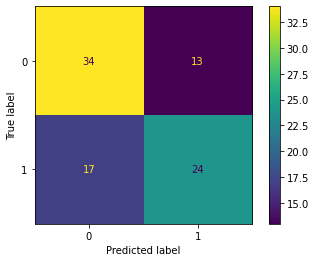

In [ ]:
plot_confusion_matrix(modelo_arvore, X_test, y_test)

In [ ]:
VP = 24
VN = 34
FP = 13
FN = 17

In [ ]:
print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



In [ ]:
prob_arvore = modelo_arvore.predict_proba(X_test)
roc_auc_score(y_test, prob_arvore[:, 1])

0.6543850544888428

In [ ]:
def roda_modelo(modelo, dados):
  x_columns = dados.columns
  y = dados['ICU']
  X = dados[x_columns].drop(['ICU', 'WINDOW'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  
  modelo.fit(X_train, y_train)
  predicao = modelo.predict(X_test)
  prob_predict = modelo.predict_proba(X_test)

  auc = roc_auc_score(y_test, prob_predict[:, 1])
  print(f'AUC: {auc}')
  print('\nClassification Report:')
  print(classification_report(y_test, predicao))

In [ ]:
roda_modelo(modelo_arvore, dados_limpos)

AUC: 0.6193565127140633

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



### Desafio 03: Pesquisar sobre F-score.

Acesse este [link](https://en.wikipedia.org/wiki/F-score) para saber mais.

### Desafio 04: Pesquisar e plotar a arvore de decisão criada pelo modelo.

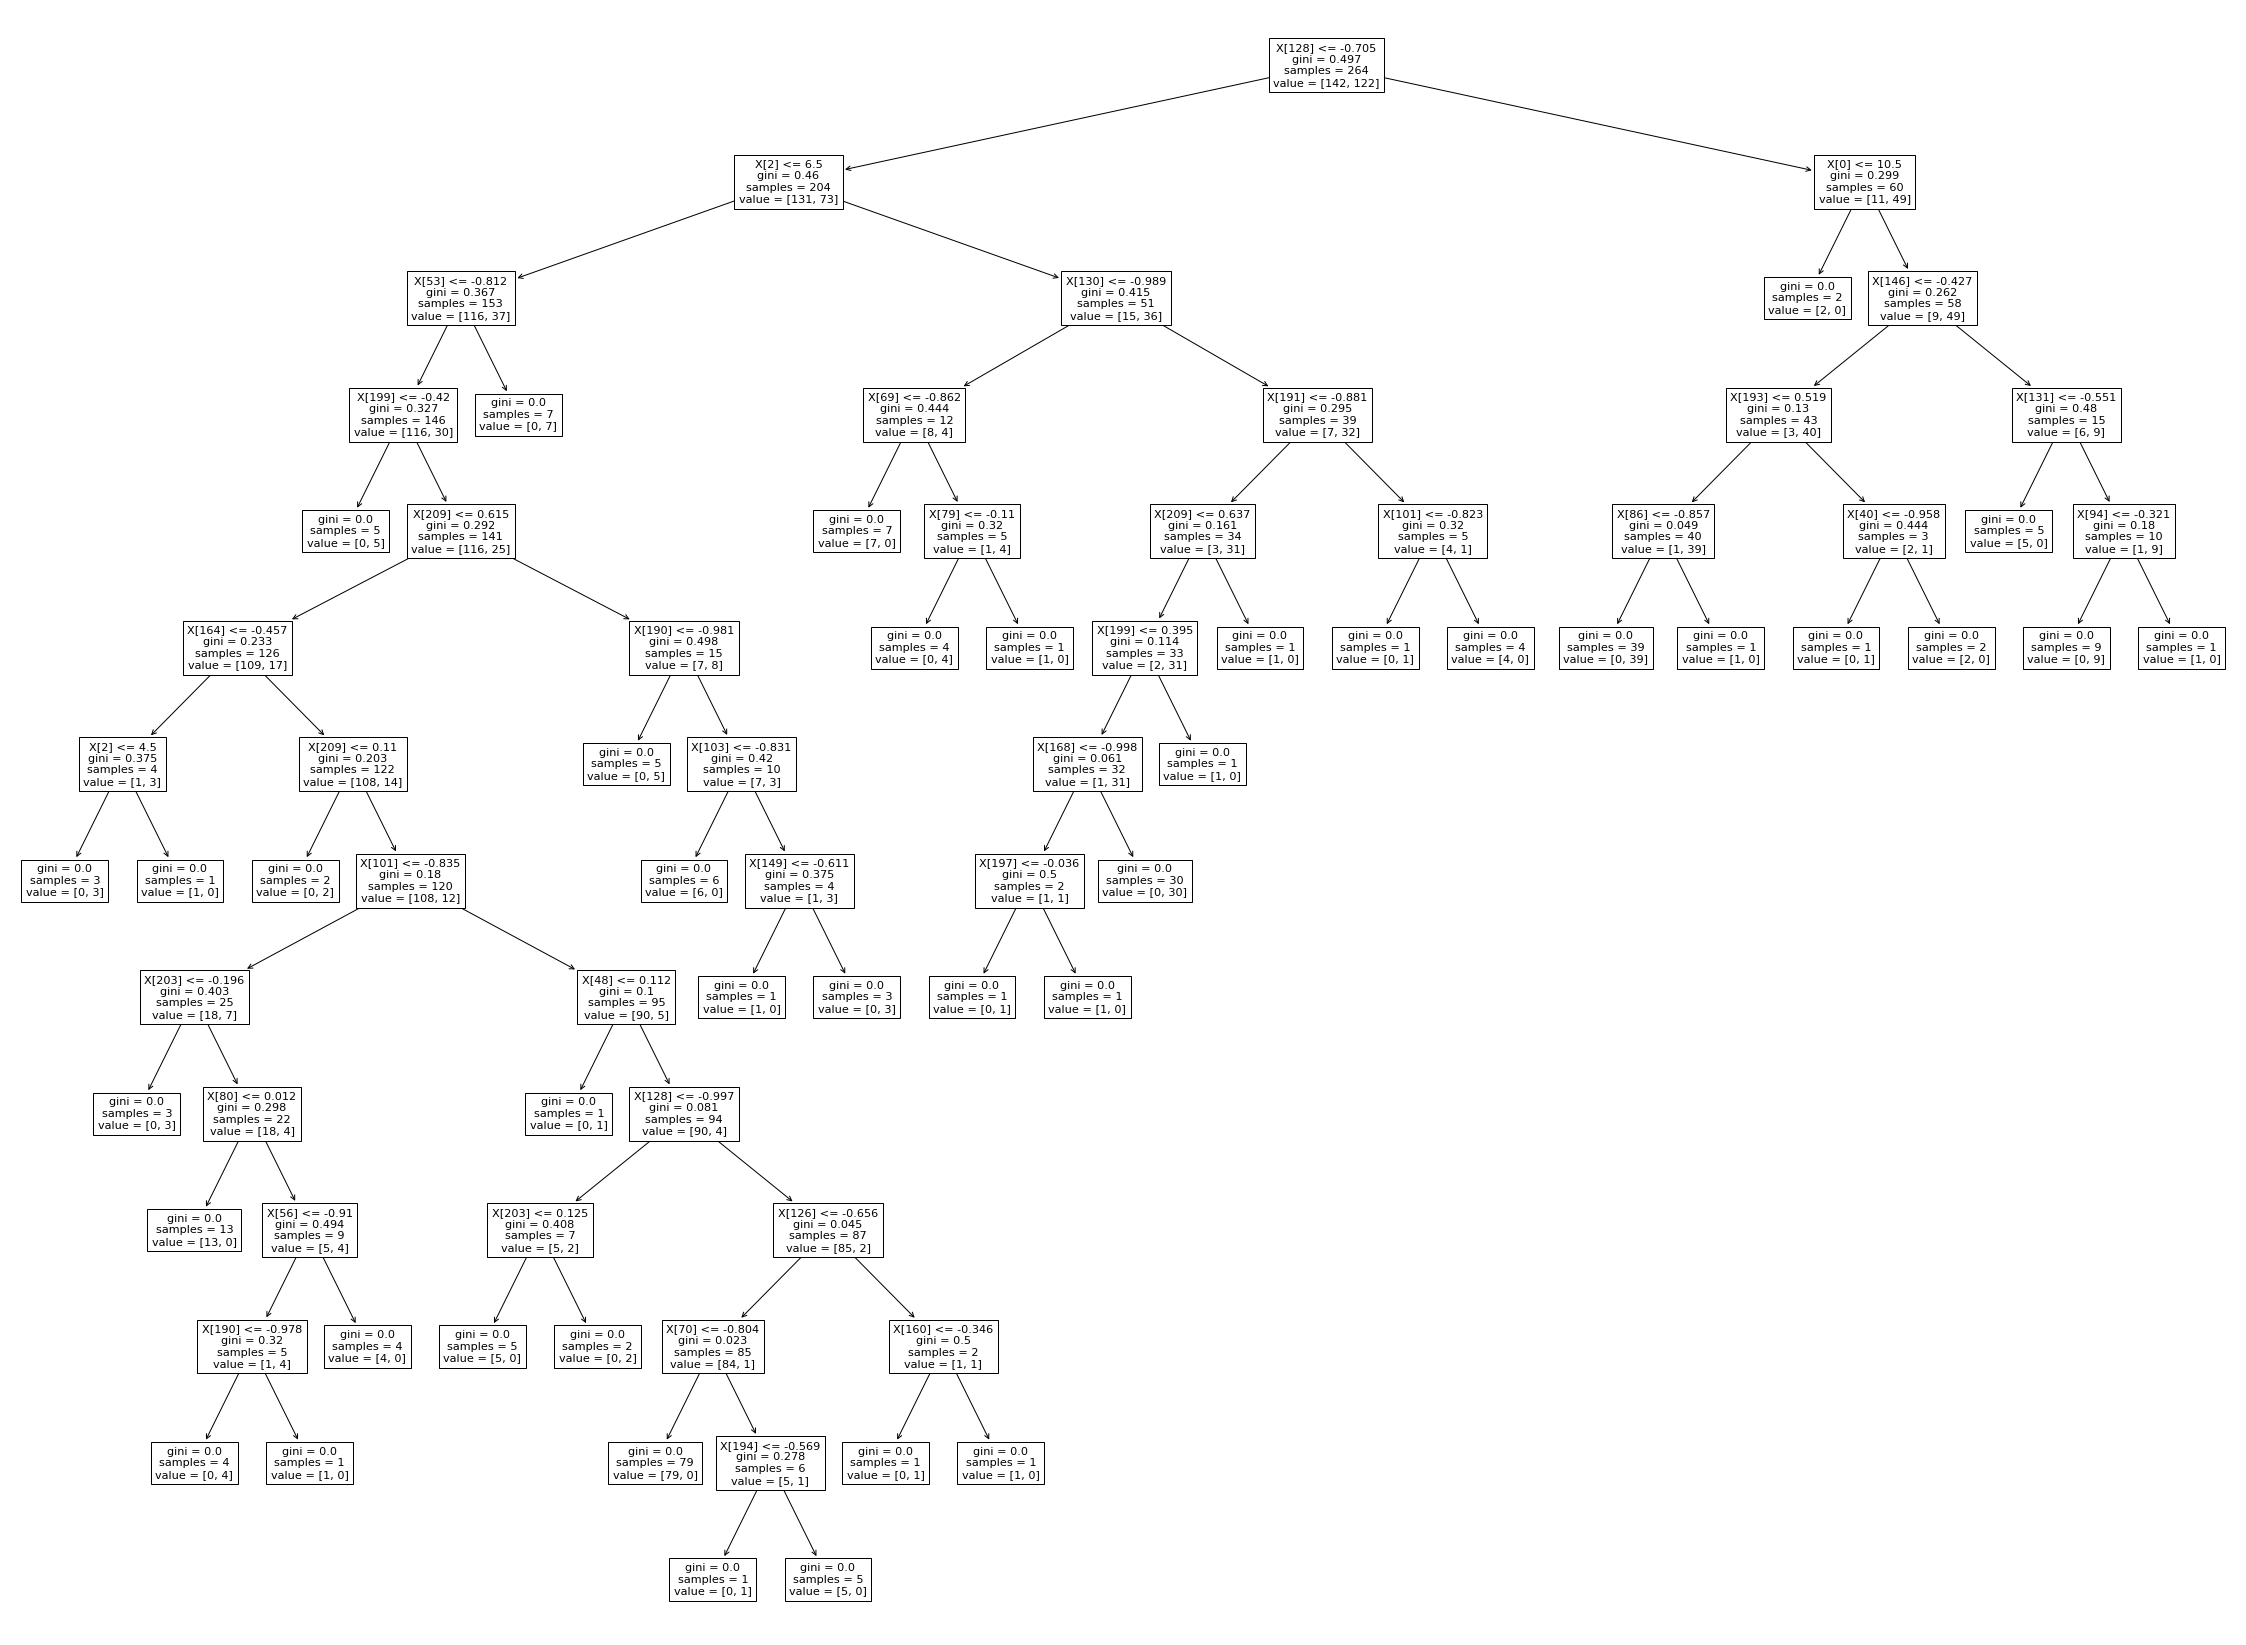

In [ ]:
plt.figure(figsize=(40, 30))
plot_tree(modelo_arvore)
plt.show()

### Desafio 05: Criar uma função que gere a curva ROC.

In [ ]:
def gera_curva_roc(models, labels):
  i = 0
  for model in models:
    predict_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predict_proba)
    plt.plot(fpr, tpr, label=labels[i])
    i += 1
  plt.title('Curva ROC')
  plt.xlabel('Falsos Positivos')
  plt.ylabel('Verdadeiros Positivos')
  plt.legend(loc='best')
  plt.show()

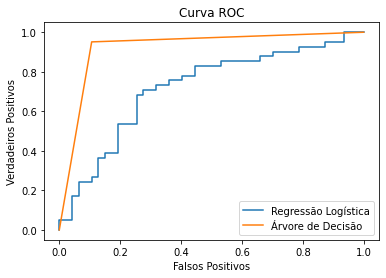

In [ ]:
gera_curva_roc([modelo, modelo_arvore], labels=['Regressão Logística', 
                                                'Árvore de Decisão'])

### Desafio 06: Pensar e tentar diminuir o efeito de aleatoriedade nas previsões.

In [ ]:
def roda_n_modelos(modelo, dados, n):
  x_columns = dados.columns
  y = dados['ICU']
  X = dados[x_columns].drop(['ICU', 'WINDOW'], axis=1)

  auc_lista = []
  for _ in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    modelo.fit(X_train, y_train)
    prob_predict = modelo.predict_proba(X_test)
    auc = roc_auc_score(y_test, prob_predict[:, 1])
    auc_lista.append(auc)

  auc_medio = np.mean(auc_lista)
  auc_std = np.std(auc_lista)
  print(f'AUC: {auc_medio}')
  print(f'Intervalo: {auc_medio - 2 * auc_std} - {auc_medio + 2 * auc_std}')

## 03. Aleatoriedade de Modelos

In [ ]:
roda_n_modelos(modelo_arvore, dados_limpos, 50)

AUC: 0.6297405293201869
Intervalo: 0.5373504569487274 - 0.7221306016916463


In [ ]:
roda_n_modelos(modelo, dados_limpos, 50)

AUC: 0.7539491437467567
Intervalo: 0.6732509731049693 - 0.8346473143885441


### Desafio 07: Estudar a documentação do sklearn e testar outros modelos.

## 04. Validação Cruzada

O `cross_validate()` basicamente divide o nosso *DataFrame* em n partes, e uma delas vai ser usada para o teste. Desse modo, vão sendo feitos treinamentos e testes de cada uma dessas diferentes partes, n vezes. Vai uma imagem:

<center><img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"></center>

Existem diferentes formas de fazer esse embaralhamento, se você estiver curioso sobre, procure mais na documentação do sklearn. Por exemplo, anteriormente utilizamos o parâmetro `stratify=y` (amostra bem representativa do nosso conjunto de dados) no `train_test_split()`, e existe uma função que faz exatamente isso, essa função é a `StratifiedKFold()`. 

Veja abaixo como essas divisões são feitas, com o código em Python.

In [ ]:
# n_plits = número de divisões dentro dos dados
# shuffe = embaralha as amostras antes de dividir em n partes

cv = StratifiedKFold(n_splits=5, shuffle=True)
cross_validate(modelo, X, y, cv=cv)

{'fit_time': array([0.52186847, 0.50534844, 0.45708013, 0.48521352, 0.39753461]),
 'score_time': array([0.00213933, 0.00204587, 0.00205374, 0.00346661, 0.00203204]),
 'test_score': array([0.70422535, 0.74647887, 0.71428571, 0.75714286, 0.71428571])}

### Desafio 08: Testar outros splitter classes e observar as diferenças.

O `RepeatedStratifiedKFold()` vai fazer a mesma coisa que o `StratifiedKFold()`, entretanto, depois que ele terminar as 5 primeiras iterações, ele vai reiniciar embaralhando outra leva dos mesmos dados, dividindo novamente em 5 partes e fazendo o mesmo procedimento! Esse processo vai ser repetido no argumento `n_repeats`.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
cross_validate(modelo, X, y, cv=cv)

{'fit_time': array([0.52871537, 0.41962862, 0.44944644, 0.55949497, 0.17677331,
        0.34799981, 0.44835687, 0.41386032, 0.41431332, 0.39072752,
        0.19365788, 0.1866765 , 0.14084578, 0.4822824 , 0.15684223,
        0.4914906 , 0.14263511, 0.17242742, 0.21112704, 0.46868539,
        0.40461493, 0.19504499, 0.22767162, 0.17777419, 0.43221068,
        0.46281576, 0.35155368, 0.40652466, 0.18894005, 0.394274  ,
        0.50933003, 0.42835402, 0.37969851, 0.2419405 , 0.5081811 ,
        0.65709186, 0.51458383, 0.44624543, 0.47119617, 0.54831815,
        0.18282533, 0.1545856 , 0.18667746, 0.5153389 , 0.41805625,
        0.43981719, 0.14486432, 0.18181443, 0.44035292, 0.1926198 ]),
 'score_time': array([0.00201392, 0.00202084, 0.00229168, 0.00205135, 0.00162482,
        0.00253201, 0.00201869, 0.00206423, 0.00213695, 0.00190425,
        0.00208306, 0.00202727, 0.00204802, 0.00212097, 0.00205445,
        0.00205684, 0.0021069 , 0.00210381, 0.00202751, 0.00208402,
        0.00205946, 

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):
  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True)

  x_columns = dados.columns
  y = dados['ICU']
  X = dados[x_columns].drop(['ICU', 'WINDOW'], axis=1)

  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, X, y, cv=cv, scoring='roc_auc')

  auc_medio = np.mean(resultados['test_score'])
  auc_std = np.std(resultados['test_score'])

  print(f'AUC Médio: {auc_medio}')
  print(f'Intervalo: {auc_medio - 2 * auc_std} - {auc_medio + 2 * auc_std}')

In [ ]:
roda_modelo_cv(modelo, dados_limpos, 5, 10)

AUC Médio: 0.7575511875511876
Intervalo: 0.6366273412799195 - 0.8784750338224556


In [ ]:
roda_n_modelos(modelo, dados_limpos, 50)

AUC: 0.7611728074727554
Intervalo: 0.6552383213129391 - 0.8671072936325717


## Desafios em Machine Learning

In [ ]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Médio: 0.6279279683391525
Intervalo: 0.4988394445682657 - 0.7570164921100394


In [ ]:
# Testando com vários números em max_depth
modelo_arvore = DecisionTreeClassifier(max_depth=4)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Médio: 0.6554932930837536
Intervalo: 0.5297661979528577 - 0.7812203882146495


In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):
  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True)

  x_columns = dados.columns
  y = dados['ICU']
  X = dados[x_columns].drop(['ICU', 'WINDOW'], axis=1)

  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, X, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])

  print(f'AUC {auc_medio} - {auc_medio_treino}')
  return auc_medio, auc_medio_treino

In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth=6)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.6239047951959137 - 0.9567921210944048


(0.6239047951959137, 0.9567921210944048)

In [ ]:
teste_lista = []
treino_lista = []

for i in range(1, 15):
  modelo_arvore = DecisionTreeClassifier(max_depth=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5755830262080263 - 0.6445982993536308
AUC 0.6544700741411268 - 0.75415524801741
AUC 0.6643847795163584 - 0.8243714304989842
AUC 0.6554932930837536 - 0.8832038893699776
AUC 0.6475058192163456 - 0.9275331115338461
AUC 0.6239047951959137 - 0.9567921210944048
AUC 0.6117738776455882 - 0.9745102329260463
AUC 0.5987671815056683 - 0.9855938255169409
AUC 0.5877544694814432 - 0.991376822665679
AUC 0.5917582923832925 - 0.9946888385564852
AUC 0.6009579413444545 - 0.9970452758822465
AUC 0.6147261533363507 - 0.9986297665919551
AUC 0.6212348996723998 - 0.9994661199548005
AUC 0.6256292095025647 - 0.9998695491440995


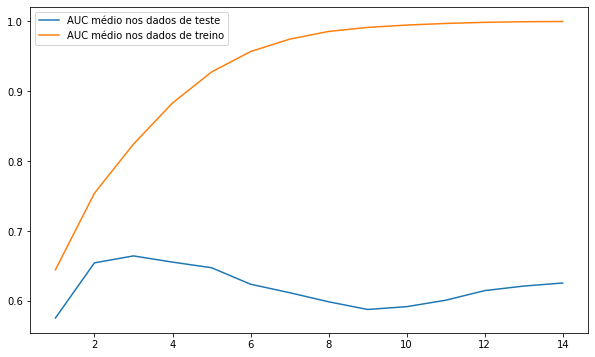

In [ ]:
x = range(1, 15)
plt.figure(figsize=(10, 6))
plt.plot(x, teste_lista, label='AUC médio nos dados de teste')
plt.plot(x, treino_lista, label='AUC médio nos dados de treino')
plt.legend()

In [ ]:
teste_lista = []
treino_lista = []

for i in range(1, 5):
  modelo_arvore = RandomForestClassifier(max_depth=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.7754785968683994 - 0.8549995635150238
AUC 0.7868632672744513 - 0.8976687127896622
AUC 0.7931550390103022 - 0.9403124842531797
AUC 0.7983565832578993 - 0.9709123570096604


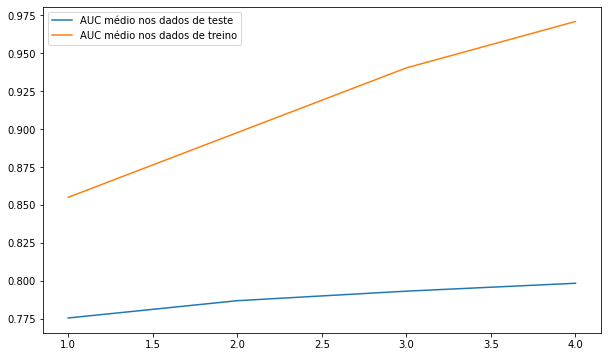

In [ ]:
x = range(1, 5)
plt.figure(figsize=(10, 6))
plt.plot(x, teste_lista, label='AUC médio nos dados de teste')
plt.plot(x, treino_lista, label='AUC médio nos dados de treino')
plt.legend()

In [49]:
for i in [10, 100, 200]:
  print(f'n_estimators: {i}')
  modelo_arvore = RandomForestClassifier(n_estimators=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  print()

n_estimators: 10
AUC 0.7428159147484805 - 0.999444041300827

n_estimators: 100
AUC 0.7939557739557739 - 1.0

n_estimators: 200
AUC 0.7950421219664641 - 1.0



### Desafio 09: Deixar o gráfico de AUC bonitão.

In [ ]:
teste_lista = []
treino_lista = []

for i in range(1, 15):
  modelo_arvore = DecisionTreeClassifier(max_depth=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5755830262080263 - 0.6445982993536308
AUC 0.6544700741411268 - 0.75415524801741
AUC 0.6643847795163584 - 0.8243714304989842
AUC 0.6554932930837536 - 0.8832038893699776
AUC 0.6475058192163456 - 0.9275331115338461
AUC 0.6239047951959137 - 0.9567921210944048
AUC 0.6117738776455882 - 0.9745102329260463
AUC 0.5987671815056683 - 0.9855938255169409
AUC 0.5877544694814432 - 0.991376822665679
AUC 0.5917582923832925 - 0.9946888385564852
AUC 0.6009579413444545 - 0.9970452758822465
AUC 0.6147261533363507 - 0.9986297665919551
AUC 0.6212348996723998 - 0.9994661199548005
AUC 0.6256292095025647 - 0.9998695491440995


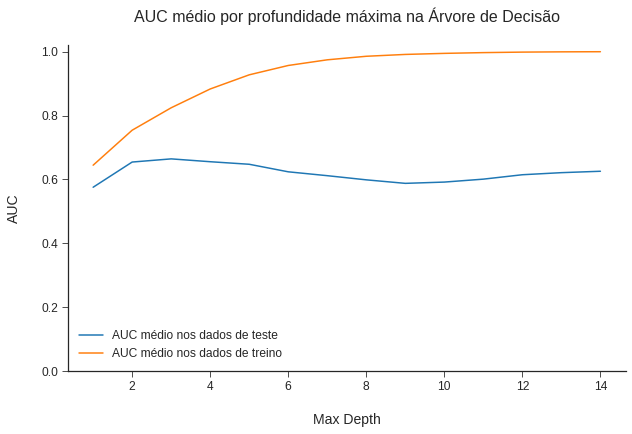

In [ ]:
x = range(1, 15)
plt.style.use('seaborn-ticks')
plt.figure(figsize=(10, 6))
plt.plot(x, teste_lista, label='AUC médio nos dados de teste')
plt.plot(x, treino_lista, label='AUC médio nos dados de treino')
plt.ylim(0)
plt.legend(fontsize=12)
plt.xlabel('\nMax Depth', fontsize=14)
plt.ylabel('AUC\n', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('AUC médio por profundidade máxima na Árvore de Decisão\n',
          fontsize=16)
sns.despine()

### Desafio 10: Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic).

### Desafio 11: Estudar um pouco mais sobre overfit e underfit.

### Desafio 12: Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários hiperparâmetros.

### Desafio 13: Pesquisar como salvar um modelo treinado.

## Finalizando a validação

In [51]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 659.8+ KB


In [52]:
dados_limpos.select_dtypes(exclude='float64')

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


In [58]:
alta_corr = 0.95
matrix_corr = dados_limpos.iloc[:, 4:-2].corr().abs()

In [67]:
matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > alta_corr)]
excluir

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEDIAN',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEDIAN',
 'NEUTROPHILES_MEA

In [94]:
def remove_corr_var(dados, valor_corte):
  matrix_corr = dados.iloc[:, 4:-2].corr().abs()
  matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
  excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

  return dados.drop(excluir, axis=1)

In [70]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos, 0.95)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

In [72]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.7950421219664641 - 1.0


(0.7950421219664641, 1.0)

In [73]:
roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC 0.8042220502500108 - 1.0


(0.8042220502500108, 1.0)

### Desafio 14: Ler no Sklearn sobre feature selection, feature importance.

### Desafio 15: Plotar também a matriz de confusão.

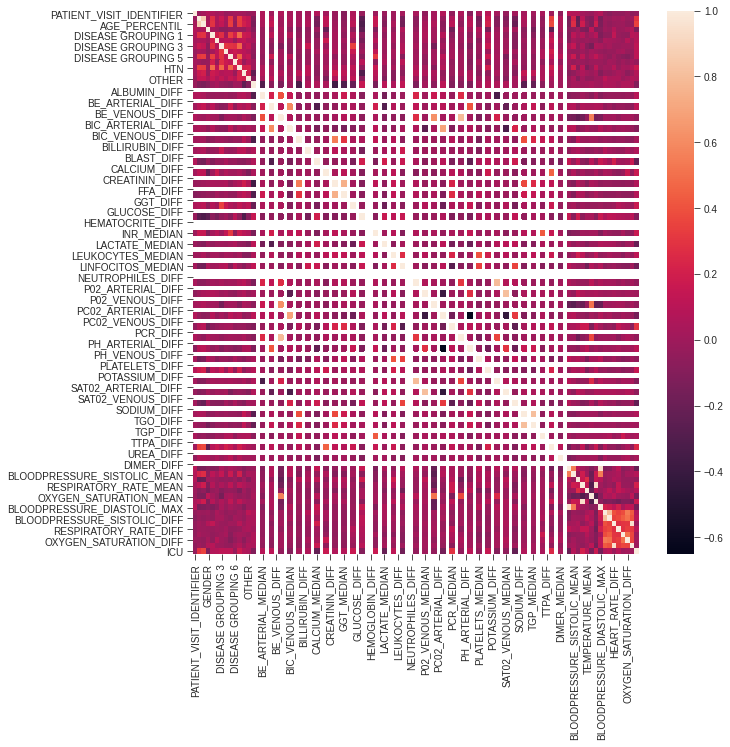

In [98]:
plt.figure(figsize=(10, 10))
sns.heatmap(dados_limpos_sem_corr.corr())

### Desafio 16: Repassar pelo desafio 12, com as bases de dados alteradas.

### Desafio Extra: Criar um pipeline de treinamento.

## Extra

### Otimização de parâmetros

Mesmo após comparar dois algoritmos e escolher qual é o melhor, ainda existe espaço para explorar os algoritmos e encontrar o melhor modelo, faremos isso através dos hiperparâmetros.

Os hiperparâmetros são características do seu modelo que podem ser definidas através dos parâmetros, por exemplo o DecisionTreeClassifier conta com parâmetros max_depth e min_samples_split que dependendo do valor vão te entregar um modelo melhor adaptado aos seus dados.

Mas isso nos trás uma questão, basta olhar para a documentação de algum desses algoritmos e vamos notar a infinidade de parâmetros que temos e assim muitas possibilidades. Para esse problema vamos ter duas soluções, definir os valores e hiperparâmetros que vamos explorar ou explorar aleatoriamente, essas duas estratégias estão implementadas no scikit-learn, o GridSearchCV e o RandomizedSearchCV

Vamos começar pelo GridSearchCV, ele nos permite definir um espaço que queremos explorar, por exemplo:

In [ ]:
espaco_de_parametros = {
  "max_depth" : [3, 5],
  "min_samples_split" : [32, 64, 128],
  "min_samples_leaf" : [32, 64, 128],
  "criterion" : ["gini", "entropy"]
}

Aqui definimos um dicionário onde a chave é o nome do parâmetro que queremos otimizar e o valor é uma lista com os valores que queremos que ele explore. Então nesse caso ele vai treinar a árvore usando uma profundidade máxima, max_depth, 3 e 5.

Para usar o GridSearchCV vamos repetir alguns parâmetro que usamos no cross_validate.

Código da aula:

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

A novidade vai ser que não vamos mandar o x e o y, e vamos usar o parâmetro param_grid que será o nosso dicionário.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

busca = GridSearchCV(modelo,              
                     param_grid=espaco_de_parametros,
                     cv = cv, scoring='roc_auc',
                     return_train_score=True)
busca.fit(x, y)

resultados = pd.DataFrame(busca.cv_results_).iloc[busca.best_index_]

Outra diferença que temos é que teremos mais de um modelo, então precisamos selecionar o que teve o melhor desempenho, temos acesso a ele por busca.best_index_ e então selecionamos eles dentro dos nossos resultados.

In [ ]:
resultados = pd.DataFrame(busca.cv_results_).iloc[busca.best_index_]

auc_medio = resultados['mean_test_score']
auc_medio_treino = resultados['mean_train_score']

auc_std = resultados['std_test_score']

Com isso, conseguimos descobrir o melhor modelo dentre o grupo de parâmetros que definimos, mas isso pode ser um problema, porque o espaço de possibilidade é bem maior, então a melhor combinação de parâmetros pode estar em outro lugar nesse espaço, pensando nisso temos a segunda solução, o RandomizedSearchCV nele vamos definir o espaço que queremos explorar e ele aleatoriamente vai testar as combinações de hiperparâmetros, e ele vai testar a quantidade que você determinar pelo parâmetro n_iter, número de interações.

Primeiro vamos definir esse espaço, veja que agora podemos incluir um grande número de possibilidades, já que não serão todas testadas, por exemplo no min_samples_split vamos testar números aleatórios entre 32 e 129.

In [ ]:
from scipy.stats import randint

espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

Com o espaço definido podemos seguir para utilização do RandomizedSearchCV, veja que vamos usar de maneira semelhante ao GridSearchCV porém com um parâmetro a mais o n_iter, que é a quantidade de combinações que ele vai tentar.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

busca = RandomizedSearchCV(modelo, param_distributions=espaco_de_parametros,
                           n_iter = n_iter, cv = cv, scoring='roc_auc',
                           return_train_score=True)
busca.fit(x, y)

Para poder comparar os resultados, modifiquei a função apresentada na aula para utilizar esses otimizadores de hiperparâmetros:

Primeiro o GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV

def roda_modelo_GridSearchCV(modelo, dados, n_splits, n_repeats, espaco_de_parametros):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)


    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

    busca = GridSearchCV(modelo, param_grid=espaco_de_parametros,
                         cv = cv, scoring='roc_auc',
                         return_train_score=True)
    busca.fit(x, y)

    resultados = pd.DataFrame(busca.cv_results_)

    auc_medio = resultados.iloc[busca.best_index_]['mean_test_score']
    auc_medio_treino = resultados.iloc[busca.best_index_]['mean_train_score']

    auc_std = resultados.iloc[busca.best_index_]['std_test_score']

    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino    

Depois o RandomizedSearchCV:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def roda_modelo_RandomizedSearchCV(modelo, dados, n_splits, n_repeats, espaco_de_parametros, n_iter):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)


    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

    busca = RandomizedSearchCV(modelo, param_distributions=espaco_de_parametros,
                                n_iter = n_iter, cv = cv, scoring='roc_auc',
                                return_train_score=True)
    busca.fit(x, y)

    resultados = pd.DataFrame(busca.cv_results_)

    auc_medio = resultados.iloc[busca.best_index_]['mean_test_score']
    auc_medio_treino = resultados.iloc[busca.best_index_]['mean_train_score']

    auc_std = resultados.iloc[busca.best_index_]['std_test_score']

    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino    

Com isso podemos notar que podemos explorar ainda mais os algoritmos, recomendo explorar a documentação dos algoritmos que estiver trabalhando e verificar se há hiperparâmetros a serem explorados neles e encontrar o melhor para os seus dados e seu objetivo.

### Pipelines

Encontrar o melhor o modelo vai ficando mais complexo conforme aprendemos novas etapas como normalização de dados, validação cruzada e otimização de parâmetros. Pensando em resolver essa complexidade e evitar erros nesses processos, vamos conhecer um recurso do scikit-learn, os pipelines e o que eles nos permitem, como por exemplo fixar uma sequência linear de etapas, que são:

[Dados], [processamento de dados], [seleção de características], [normalização], [classificação].
Vantagens:

Código mais legível
Dificulta o vazamento de dados
O scikit-learn nos permite construir essa estrutura através do Pipeline e para utilizá-lo definimos a sequência de passos utilizando uma lista que é composta de tuplas e essa por sua vez, terá o nome da etapa e a classe:

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('nome_etapa1', SelectKBest()),
                 ('nome_etapa2', Normalized()),
                 ('modelo',  LogisticRegression())])

Com o Pipeline criado, ele será utilizado no lugar do modelo, por exemplo no cross_validate ou GridSearchCV.

No exemplo optei por criar a nossa própria etapa, e ela será baseada na função aprendida na aula a remove_corr_var

In [ ]:
def remove_corr_var(dados, valor_corte):

    matrix_corr = dados.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

    return dados.drop(excluir, axis=1)

Essa função identificou as colunas com alta correlação e as removeu, vamos repetir ela, mas agora dentro do nosso processo de treinamento.

Quando o cross_validation separa nossos dados em teste e treino, a ideia é que a nossa função leia os dados de treino, identifique as colunas com alta correlação e as remova tanto dos dados de treino quanto dos dados de teste.

Não vou me aprofundar muito nos conceitos de Orientação Objeto, mas para criarmos essa solução precisamos criar uma classe, optei pelo nome RemoveCorrVar e nela vamos construir nossa estratégia. Para o Pipeline aceitar nossa classe precisamos colocar entre parênteses (BaseEstimator, TransformerMixin) que são outras classes que o pipeline requisita. Vamos também criar esse __init__ e nele definir o valor_corte, que é o valor de correlação máxima que vamos manter.

A parte de encontrar as colunas com alta correlação vai ficar dentro do fit que por padrão vai receber os nossos dados X e Y.

In [ ]:
class RemoveCorrVar(BaseEstimator, TransformerMixin):
    def __init__( self, valor_corte = 0.95):
        self.valor_corte = valor_corte

    def fit( self, X, y = None ):
        matrix_corr = X.iloc[:,4:].corr().abs()
        matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > self.valor_corte)]
        return self 

Você deve ter notado que não retiramos as colunas ainda, apenas salvamos elas na variável self.excluir . O motivo disso é que temos um trecho específico para isso, ele é chamado de transform, o drop vai ficar nesse trecho para que ele seja aplicado tanto nos dados de treino, quanto nos de teste.

In [ ]:
class RemoveCorrVar(BaseEstimator, TransformerMixin):
    def __init__( self, valor_corte = 0.95):
        self.valor_corte = valor_corte

    def fit( self, X, y = None ):
        matrix_corr = X.iloc[:,4:].corr().abs()
        matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > self.valor_corte)]
        return self 

    def transform(self, X, y = None):
        X = X.drop(self.excluir, axis=1)
        return X

Com a etapa pronta, podemos incluí-la no Pipeline, optei pelo nome cat_selector, seletor de características.

In [ ]:
 pipeline = Pipeline([('cat_selector', RemoveCorrVar()),
                         ('Modelo', modelo)])   

Finalmente podemos utilizar agora o pipeline no lugar do modelo dentro da função roda_modelo_cv criada na aula.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

def roda_modelo_cv_pipeline(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    pipeline = Pipeline([('cat_selector', RemoveCorrVar()),
                         ('Modelo', modelo)])    

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(pipeline, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])

    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    return auc_medio, auc_medio_treino)

Então agora cada vez que nosso modelo for treinado no cross_validate antes ele vai remover as colunas que julgamos desnecessárias.

Existem diversas etapas já prontas no sklearn para o processamento dos dados, por exemplo o StandardScaler que vai escalar os valores do seus dados, então recomendo procurar por outras soluções que fazem sentido para o seus dados e que podem ser adicionadas ao seu Pipeline.

### Salvando seu modelo

Depois de treinado seu modelo pode ser salvo, e com isso poderá utilizar ele em outro projeto, por exemplo um projeto web. Existem diversos caminhos para isso, como pode ver na documentação.

Hoje vou apresentar um exemplo usando a biblioteca joblib

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x, y)

from joblib import dump, load
dump(modelo_arvore, 'filename.joblib') 


Utilizamos a função dump, colocamos o primeiro parâmetro com a variável que contem nosso modelo treinado, no caso a modelo_arvore e depois o nome do arquivo que será gerado e guardará nosso modelo.

E quando estiver em um novo projeto e quiser usar aquele modelo já treinado poderá usar a função load

In [ ]:
modelo_arvore = load('filename.joblib') 